In [ ]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point


In [ ]:
from matplotlib import pyplot as plt
import pickle
import os
import scipy
import importlib

from scipy import signal
import numpy as np

import emcee
import lmfit
import pandas as pd
import xarray as xr
from eofs.xarray import Eof
import re

In [ ]:
import prpatt as prpatt

In [ ]:
datadir='/storage/qbo/users/bensan/'

Find available experiments

Open and concatenate xarray datasets

In [ ]:

expts=['base',
 'ch4x3',
 'bcslt',
 'solar',
 'sulx5',
 'co2x2',
 'cfc12',
 'bcx10',
 'base2',
 'cfc11',
 'n2o1p']

In [ ]:
for i,expt in enumerate(expts):
    tmp=xr.open_dataset(datadir+"training/pdrmip-"+expt+"_T42_ANN.nc")
    if i==0:
        dac=tmp
    else:
        dac=xr.concat([dac,tmp],'expt')

In [ ]:
dac=dac.assign_coords({"expt": expts})
dac

Create anomaly matrix from base experiment

In [ ]:
ctrl=expts.index("base")

In [ ]:
vars=dac.data_vars
dacanom=dac
for var in vars:
    dacanom[var]=dac[var]-dac[var][ctrl,:,:,:,:].mean(dim='year',skipna=True)
dacanom=dacanom.rename({'year': 'time'})

In [71]:
flds = ['tas','pr']#[i for i in dacanom.data_vars] 
flds

['tas', 'pr']

In [72]:
mdls=list(dacanom.ens.values)

In [75]:
fldtrnc=[2,10]
tmscl=[2,50]

In [76]:
od=dict()
mav=np.zeros([len(mdls),len(expts),len(flds)])
for i,mdl in enumerate(mdls):
    od[mdl]=dict()

    for j,expt in enumerate(expts):
        od[mdl][expt]=dict()
        for k,fld in enumerate(flds):
            od[mdl][expt][fld]=dict()
            
            X=dacanom[fld][j,:100,:,:,i]
            if ~np.isnan(np.mean(X)):
                print(mdl+' '+expt+' '+fld)
                mav[i,j,k]=1
                (ts,out,us,orgeof,neweof)=prpatt.get_timescales(X,tmscl,fldtrnc[k])
                od[mdl][expt][fld]['neweof']=neweof
                od[mdl][expt][fld]['orgeof']=orgeof
                od[mdl][expt][fld]['outp']=out
                
            else:
                od[mdl][expt][fld]['neweof']=np.nan
                od[mdl][expt][fld]['orgeof']=np.nan

CanESM2 base tas
CanESM2 base pr
CanESM2 ch4x3 tas
CanESM2 ch4x3 pr
CanESM2 solar tas
CanESM2 solar pr
CanESM2 sulx5 tas
CanESM2 sulx5 pr
CanESM2 co2x2 tas
CanESM2 co2x2 pr
CanESM2 bcx10 tas
CanESM2 bcx10 pr
ECHAM-HAM base tas
ECHAM-HAM base pr
ECHAM-HAM bcslt tas
ECHAM-HAM bcslt pr
ECHAM-HAM cfc12 tas
ECHAM-HAM cfc12 pr
ECHAM-HAM bcx10 tas
ECHAM-HAM bcx10 pr
ECHAM-HAM base2 tas
ECHAM-HAM base2 pr
ECHAM-HAM cfc11 tas
ECHAM-HAM cfc11 pr
ECHAM-HAM n2o1p tas
ECHAM-HAM n2o1p pr
GISS-E2-R base tas
GISS-E2-R base pr
GISS-E2-R ch4x3 tas
GISS-E2-R ch4x3 pr
GISS-E2-R bcslt pr
GISS-E2-R solar tas
GISS-E2-R solar pr
GISS-E2-R sulx5 tas
GISS-E2-R sulx5 pr
GISS-E2-R co2x2 tas
GISS-E2-R co2x2 pr
GISS-E2-R cfc12 tas
GISS-E2-R cfc12 pr
GISS-E2-R bcx10 tas
GISS-E2-R bcx10 pr
HadGEM2 base tas
HadGEM2 base pr
HadGEM2 ch4x3 tas
HadGEM2 ch4x3 pr
HadGEM2 solar tas
HadGEM2 solar pr
HadGEM2 sulx5 tas
HadGEM2 sulx5 pr
HadGEM2 co2x2 tas
HadGEM2 co2x2 pr
HadGEM2 cfc12 tas
HadGEM2 cfc12 pr
HadGEM2 bcx10 tas
HadGE

In [ ]:
od[mdl][expt][fld]['orgeof']

In [ ]:
mdl='CanESM2'
expt='co2x2'
fld='tas'

p,ax=plt.subplots(4,3)
ax=ax.flatten()
p.set_size_inches(8,10)
for i,mdl in enumerate(mdls):
    X=dacanom[fld][expts.index(expt),:100,:,:,mdls.index(mdl)]
    ax[i].plot(prpatt.global_mean(X),label='Original Data')
    try:
        ax[i].plot(prpatt.global_mean(prpatt.recon(od[mdl][expt][fld]['orgeof'])),label='EOF reconstruction (t=2)')
        ax[i].plot(prpatt.global_mean(prpatt.recon(od[mdl][expt][fld]['neweof'])),label='P-R fit to PCs (t=2)')
        ax[i].set_xlabel('time (years)')
        ax[i].legend()
        ax[i].set_title(mdl)
    except:
        print('no data')


In [ ]:
expts

In [ ]:

p,ax=plt.subplots(2,1)
p.set_size_inches(8,10)
plt.set_cmap('bwr')
od['CanESM2']['co2x2']['tas']['orgeof']['v'][0,:,:].plot(ax=ax[0],cmap='bwr',vmin=-0.0001,vmax=0.0001)
od['CanESM2']['co2x2']['tas']['orgeof']['v'][1,:,:].plot(ax=ax[1])



In [ ]:
od['CanESM2']['co2x2']['tas'].keys()

In [ ]:
Xp=dacanom['tas'][expts.index('co2x2'),:100,:,:,mdls.index('CanESM2')]
Xrp=prpatt.recon(od['CanESM2']['co2x2']['tas']['orgeof'])
Xrs=prpatt.recon(od['CanESM2']['co2x2']['tas']['neweof'])



In [ ]:
Xp.weighted(prpatt.wgt(Xp)).mean(('lat','lon')).plot(color='cyan')
Xrp.weighted(prpatt.wgt(Xp)).mean(('lat','lon')).plot(color='k')
Xrs.weighted(prpatt.wgt(Xp)).mean(('lat','lon')).plot(color='red')



Text(0.5, 1.0, 'actual-emulated year 0 abrupt4x')

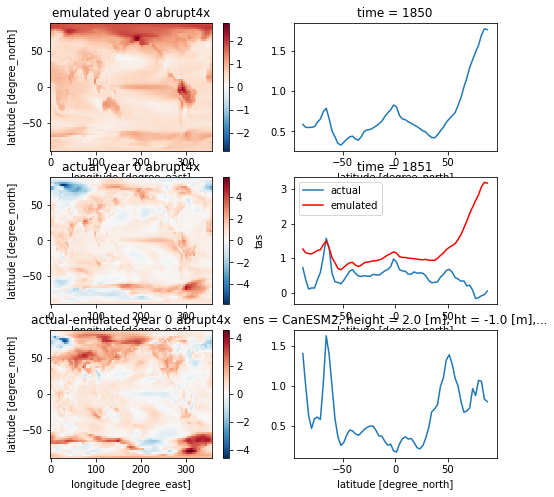

In [61]:
p,ax=plt.subplots(3,2)
p.set_size_inches(8,8)
Xrs[0,:,:].plot(ax=ax[0,0],clim=[-5,5])
Xrs[0,:,:].mean(dim='lon').plot(ax=ax[0,1])

ax[0,0].set_title('emulated year 0 abrupt4x')
X[0,:,:].plot(ax=ax[1,0])
X[0,:,:].mean(dim='lon').plot(ax=ax[1,1],label='actual')
Xrs[1,:,:].mean(dim='lon').plot(ax=ax[1,1],color='r',label='emulated')
ax[1,1].legend()
ax[1,0].set_title('actual year 0 abrupt4x')
(X[1,:,:]-Xrs[0,:,:]).plot(ax=ax[2,0])
(X[1,:,:]-Xrs[0,:,:]).mean(dim='lon').plot(ax=ax[2,1])
ax[2,0].set_title('actual-emulated year 0 abrupt4x')



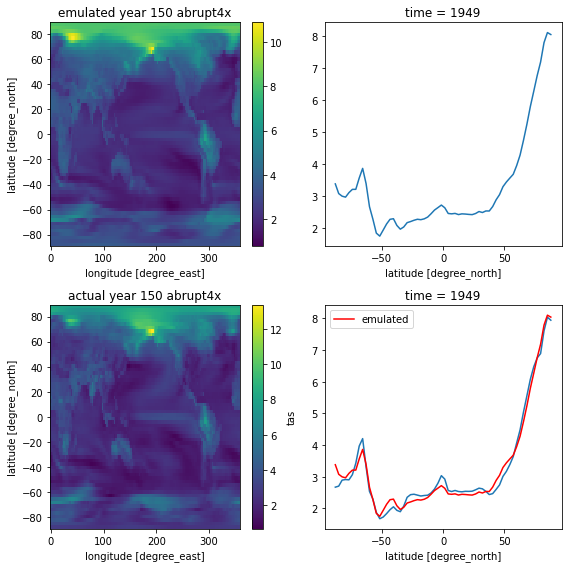

In [60]:
p,ax=plt.subplots(2,2)
p.set_size_inches(8,8)
Xrs[-1,:,:].plot(ax=ax[0,0])
Xrs[-1,:,:].mean(dim='lon').plot(ax=ax[0,1])

ax[0,0].set_title('emulated year 150 abrupt4x')
Xp[-1,:,:].plot(ax=ax[1,0])
Xp[-1,:,:].mean(dim='lon').plot(ax=ax[1,1])
Xrs[-1,:,:].mean(dim='lon').plot(ax=ax[1,1],color='r',label='emulated')
ax[1,1].legend()
ax[1,0].set_title('actual year 150 abrupt4x')

p.tight_layout()


In [ ]:
importlib.reload(prpatt)

In [62]:
#f=np.arange(0,150)*5.35*np.log(1.01)

f=5*np.exp(-np.square(np.arange(0,300)-150)/5000)


Text(0.5, 1.0, 'Idealised overshoot forcing')

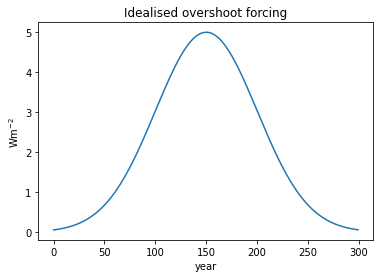

In [63]:
plt.plot(f)
plt.ylabel(r'Wm$^{-2}$')
plt.xlabel('year')
plt.title('Idealised overshoot forcing')

In [79]:
out=od['CanESM2']['co2x2']['tas']['outp']
outp=od['CanESM2']['co2x2']['pr']['outp']
orgeof=od['CanESM2']['co2x2']['tas']['orgeof']
orgeofp=od['CanESM2']['co2x2']['pr']['orgeof']



Xup=prpatt.imodel_eof(outp.params, f)
Xfp=prpatt.imodel_filter(outp.params,f)
Xsimp=prpatt.rmodel(orgeofp,Xfp)

Xu=prpatt.imodel_eof(out.params, f)
Xf=prpatt.imodel_filter(out.params,f)
Xsim=prpatt.rmodel(orgeof,Xf)



In [80]:
#plt.plot(Xf[:])
#plt.plot(Xu[:],'--')

Text(0.5, 1.0, 'CanESM2 METEOR fit')

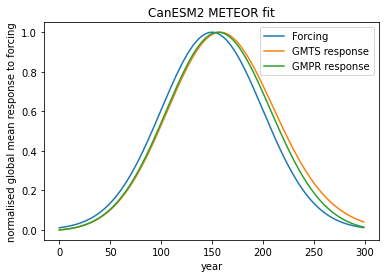

In [81]:
ts_f=Xsim.weighted(prpatt.wgt(X)).mean(('lat','lon'))
pr_f=Xsimp.weighted(prpatt.wgt(X)).mean(('lat','lon'))

plt.plot(f/np.max(f),label='Forcing')
plt.plot(ts_f/np.max(ts_f),label='GMTS response')
plt.plot(pr_f/np.max(pr_f),label='GMPR response')
#p1=Xsim.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
#Xact=ds_1pc_anom.tas[0,:150,:,:]

#p2=Xact.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
plt.ylabel('normalised global mean response to forcing')
plt.xlabel('year')
plt.legend()

plt.title('CanESM2 METEOR fit')
#plt.legend((p1[0],p2[0]),['Emulated','truth'])

Text(0.5, 1.0, 'CanESM2 METEOR emulation')

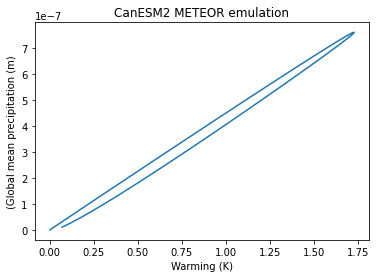

In [82]:
plt.plot(ts_f,pr_f)


plt.ylabel(r'(Global mean precipitation (m)')
plt.xlabel('Warming (K)')
plt.title('CanESM2 METEOR emulation')


In [83]:
fil=(ts_f/np.max(ts_f)>0.95)
tf=[i for i, x in enumerate(fil) if x][0]
tl=[i for i, x in enumerate(fil) if x][-1]


In [ ]:
da=3600*24*365*(Xsimp[tl,:,:]-Xsimp[tf,:,:])

projection = ccrs.PlateCarree()
crs = ccrs.PlateCarree()
# Now we will create axes object having specific projection 
plt.figure(dpi=300,figsize=(8, 5))
ax = plt.axes(projection=projection, frameon=True)

# Draw gridlines in degrees over Mercator map
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
gl.xlabel_style = {"size" : 5}
gl.ylabel_style = {"size" : 5}

# To plot borders and coastlines, we can use cartopy feature
import cartopy.feature as cf

# Now, we will specify extent of our map in minimum/maximum longitude/latitude
# Note that these values are specified in degrees of longitude and degrees of latitude
# However, we can specify them in any crs that we want, but we need to provide appropriate
# crs argument in ax.set_extent
lon_min = -180
lon_max = 180
lat_min = -80
lat_max = 80

# crs is PlateCarree -> we are explicitly telling axes, that we are creating bounds that are in degrees
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, "pad" : .05, 'aspect':40, 'label':'2 Metre Temperature Anomaly [K]'}


lon = da.coords['lon']

lon_idx = da.dims.index('lon')
wrap_data, wrap_lon = add_cyclic_point(da.values, coord=lon, axis=lon_idx)
levels = np.linspace(-60, 60, 13)

pc = ax.contourf(wrap_lon,da.lat[:],wrap_data,levels=levels,cmap='BrBG')

ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)
ax.add_feature(cf.OCEAN, zorder=100, edgecolor="k", lw=.5, facecolor='grey') 

cbar = plt.colorbar(pc, shrink=0.5, orientation="vertical") 
cbar.ax.tick_params(labelsize=5) 
cbar.ax.set_ylabel('mm')
cbar.ax.set_ylabel('mm')
#cbar.ax.set_ylabel('mm')
cbar.set_label(label='mm',size=5,weight='bold')
plt.title('Asymmetry in preciptiation at 4C warming (after-before peak)',size=5,weight='bold')
    

In [ ]:
da.lat

In [ ]:
p,ax=plt.subplots(3,1)
p.set_size_inches(8,12)
((Xsimp[tf,:,:])).plot(vmin=-.000005,vmax=.000005,cmap='BrBG',ax=ax[0])
((Xsimp[tl,:,:])).plot(vmin=-.000005,vmax=.000005,cmap='BrBG',ax=ax[1])
(3600*24*365*(Xsimp[tl,:,:]-Xsimp[tf,:,:])).plot(vmin=-100,vmax=100,cmap='BrBG',ax=ax[2])




In [ ]:

outscl=prpatt.adjust_timescales(X,Xact,out.params,ts,f)
outscl

In [ ]:
Xscl=prpatt.imodel_filter_scl(outscl.params,out.params,f)
Xsimscl=prpatt.rmodel(orgeof,Xscl)

In [ ]:
p1=Xsim.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
Xact=ds_1pc_anom.tas[0,:150,:,:]

p2=Xact.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
p3=Xsimscl.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()

plt.ylabel(r'(K)')
plt.xlabel('year')
plt.title('1pctCO2 global mean temperature response')
plt.legend((p1[0],p2[0],p3[0]),['Emulated (IR only)','truth','Emulated (IR + quadratic transform)'])

In [ ]:
Xu1=prpatt.imodel_eof(out1.params, f)
Xsim1=prpatt.rmodel(orgeof1,Xu)

In [ ]:
Xsim.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
Xact.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
Xsim1.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()


In [ ]:
inma=prpatt.imodel_filter(out.params, f, F0=7.41, y0=1850)

In [ ]:
plt.plot(f+np.square(f)/10)

In [ ]:
inma.plot.line(x='time')